<a href="https://colab.research.google.com/github/arianesannt/Tech_challenge_fase2/blob/main/Tech_challenge_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
# No colab não precisa instalar a Prophet, apenas a biblioteca yfinance

#!pip install yfinance --upgrade --no-cache-dir

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
yf.pdr_override()


# Adequação do dataset

In [3]:
# buscando dados da Ibovespa diretamente da web

dados = web.get_data_yahoo('^BVSP', period='5y')

[*********************100%%**********************]  1 of 1 completed


In [4]:
dados

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-22,96008.0,96070.0,94662.0,95103.0,95103.0,4256000
2019-01-23,95116.0,96576.0,95116.0,96558.0,96558.0,0
2019-01-24,96558.0,97677.0,96558.0,97677.0,97677.0,5019400
2019-01-28,97674.0,97937.0,94783.0,95444.0,95444.0,7185300
2019-01-29,95508.0,96751.0,95508.0,95639.0,95639.0,5262000
...,...,...,...,...,...,...
2024-01-16,131515.0,131517.0,129147.0,129294.0,129294.0,11911300
2024-01-17,129293.0,129296.0,128312.0,128524.0,128524.0,9952500
2024-01-18,128524.0,129047.0,127316.0,127316.0,127316.0,12460800


In [5]:
# para usar o prophet, vou precisar somente da data e da coluna "adj close", que são os preços ajustados

dados = dados['Adj Close']
dados

Date
2019-01-22     95103.0
2019-01-23     96558.0
2019-01-24     97677.0
2019-01-28     95444.0
2019-01-29     95639.0
                ...   
2024-01-16    129294.0
2024-01-17    128524.0
2024-01-18    127316.0
2024-01-19    127636.0
2024-01-22    126602.0
Name: Adj Close, Length: 1242, dtype: float64

In [6]:
# o prophet só trabalha com Dataframe, então precisa transformar
type(dados)

pandas.core.series.Series

In [7]:
dados = pd.DataFrame(dados)
dados

,Adj Close
Date,
2019-01-22,95103.0
2019-01-23,96558.0
2019-01-24,97677.0
2019-01-28,95444.0
2019-01-29,95639.0
...,...
2024-01-16,129294.0
2024-01-17,128524.0
2024-01-18,127316.0


In [8]:
dados.reset_index('Date', inplace=True)
dados

,Date,Adj Close
0,2019-01-22,95103.0
1,2019-01-23,96558.0
2,2019-01-24,97677.0
3,2019-01-28,95444.0
4,2019-01-29,95639.0
...,...,...
1237,2024-01-16,129294.0
1238,2024-01-17,128524.0
1239,2024-01-18,127316.0
1240,2024-01-19,127636.0


In [9]:
# o prophet só usa duas colunas que é ds e y, sendo ds a data e y o alvo
dados.columns = ['ds', 'y']
dados

,ds,y
0,2019-01-22,95103.0
1,2019-01-23,96558.0
2,2019-01-24,97677.0
3,2019-01-28,95444.0
4,2019-01-29,95639.0
...,...,...
1237,2024-01-16,129294.0
1238,2024-01-17,128524.0
1239,2024-01-18,127316.0
1240,2024-01-19,127636.0


In [10]:
#verificando se os dados estao no tipo correto para criação do modelo com prophet e no caso estão ok
dados.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [35]:
# separando a base em pre-covid e pos-covid

dados2 = dados.copy()
dados2['pre_covid'] = pd.to_datetime(dados2['ds']) < pd.to_datetime('2020-03-16')
dados2['pos_covid'] = ~dados2['pre_covid']

In [36]:
dados2

,ds,y,pre_covid,pos_covid
0,2019-01-22,95103.0,True,False
1,2019-01-23,96558.0,True,False
2,2019-01-24,97677.0,True,False
3,2019-01-28,95444.0,True,False
4,2019-01-29,95639.0,True,False
...,...,...,...,...
1237,2024-01-16,129294.0,False,True
1238,2024-01-17,128524.0,False,True
1239,2024-01-18,127316.0,False,True
1240,2024-01-19,127636.0,False,True


# Criando o modelo com Prophet

In [27]:
# usando sklearn vou criar meu conjunto de treino e meu conjunto de teste
# obs: shuffle=False significa que eu não quero embaralhar meus dados, quero que fique na ordem

dados_treino, dados_teste = train_test_split(dados2, test_size=0.3, shuffle=False)

In [28]:
dados_treino

,ds,y,pre_covid,pos_covid
0,2019-01-22,95103.0,True,False
1,2019-01-23,96558.0,True,False
2,2019-01-24,97677.0,True,False
3,2019-01-28,95444.0,True,False
4,2019-01-29,95639.0,True,False
...,...,...,...,...
864,2022-07-18,96916.0,False,True
865,2022-07-19,98245.0,False,True
866,2022-07-20,98287.0,False,True
867,2022-07-21,99033.0,False,True


In [29]:
dados_teste

,ds,y,pre_covid,pos_covid
869,2022-07-25,100270.0,False,True
870,2022-07-26,99772.0,False,True
871,2022-07-27,101438.0,False,True
872,2022-07-28,102597.0,False,True
873,2022-07-29,103165.0,False,True
...,...,...,...,...
1237,2024-01-16,129294.0,False,True
1238,2024-01-17,128524.0,False,True
1239,2024-01-18,127316.0,False,True
1240,2024-01-19,127636.0,False,True


In [30]:
# criando um modelo com o prophet
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

# adicionando os feriados
modelo.add_country_holidays(country_name='BR')

In [31]:
# treinando o modelo
modelo.fit(dados_treino)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsge025fg/mojnvuc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsge025fg/nvpme1_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53044', 'data', 'file=/tmp/tmpsge025fg/mojnvuc_.json', 'init=/tmp/tmpsge025fg/nvpme1_x.json', 'output', 'file=/tmp/tmpsge025fg/prophet_modelwszwxybd/prophet_model-20240123101007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:10:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:10:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
# criando parãmetro de predição futura (quantos dias o modelo deve prever)
futuro = modelo.make_future_dataframe(freq='D', periods=373)

In [ ]:
modelo.add_seasonality(
    name='daily_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
modelo.add_seasonality(
    name=daily_post_covid',
    period=7,
    fourier_order=3,
    condition_name='pos_covid',
);

In [33]:
# vou criar uma previsão com base no modelo que eu treinei
previsao_teste = modelo.predict(futuro)


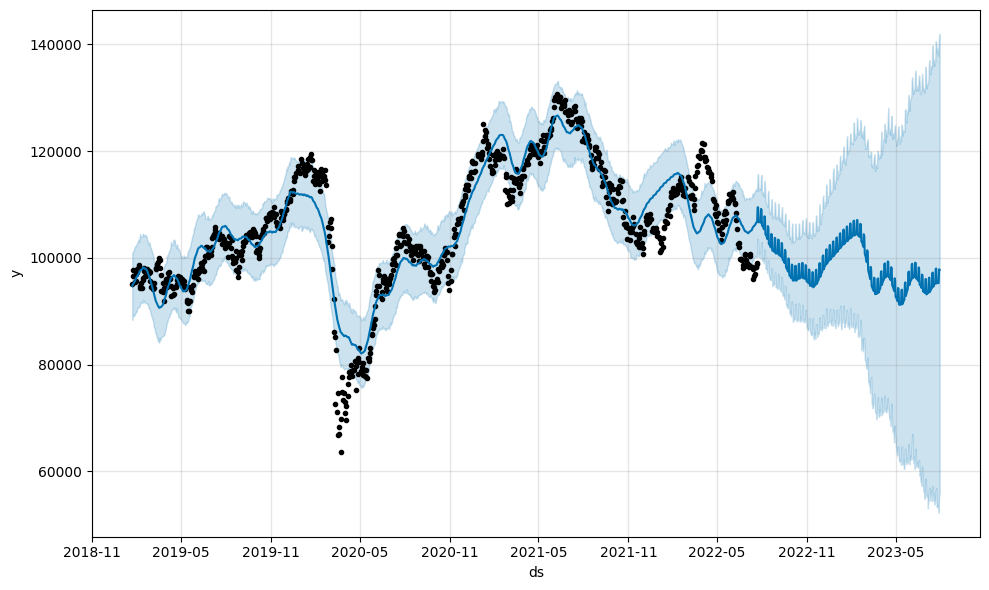

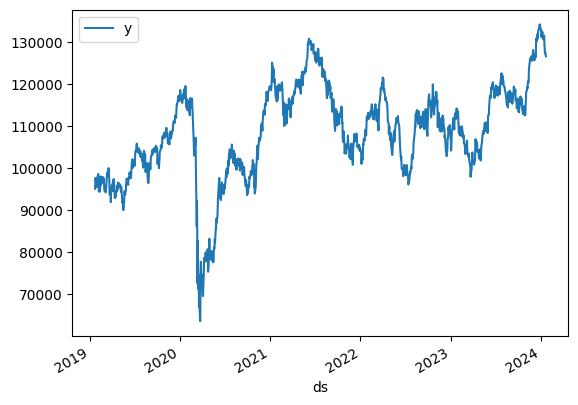

In [34]:
modelo.plot(previsao_teste)
dados.plot(x='ds', y='y')
plt.show()